<a href="https://colab.research.google.com/github/Kev007s/Big-data-analisis-semester-5/blob/main/Revisi_Analisis_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logging

# Clustering libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# Time series forecasting libraries
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
data1 = pd.read_excel('/content/sample_data/PENJUALAN JAN-MARET(test).xlsx')
data2 = pd.read_excel('/content/sample_data/PENJUALAN APRIL - JUNI 2024(test).xlsx')

data = pd.concat([data1, data2], ignore_index=True)
data = data[~data['Invoice Date'].astype(str).str.contains('Subtotal', na=False)]
data = data[pd.to_datetime(data['Invoice Date'], errors='coerce').notna()]
data['Invoice Date'] = pd.to_datetime(data['Invoice Date'])
data = data.ffill()

data.to_csv('/content/Download/updated_file.csv', index=False)  # Save to /content/Download

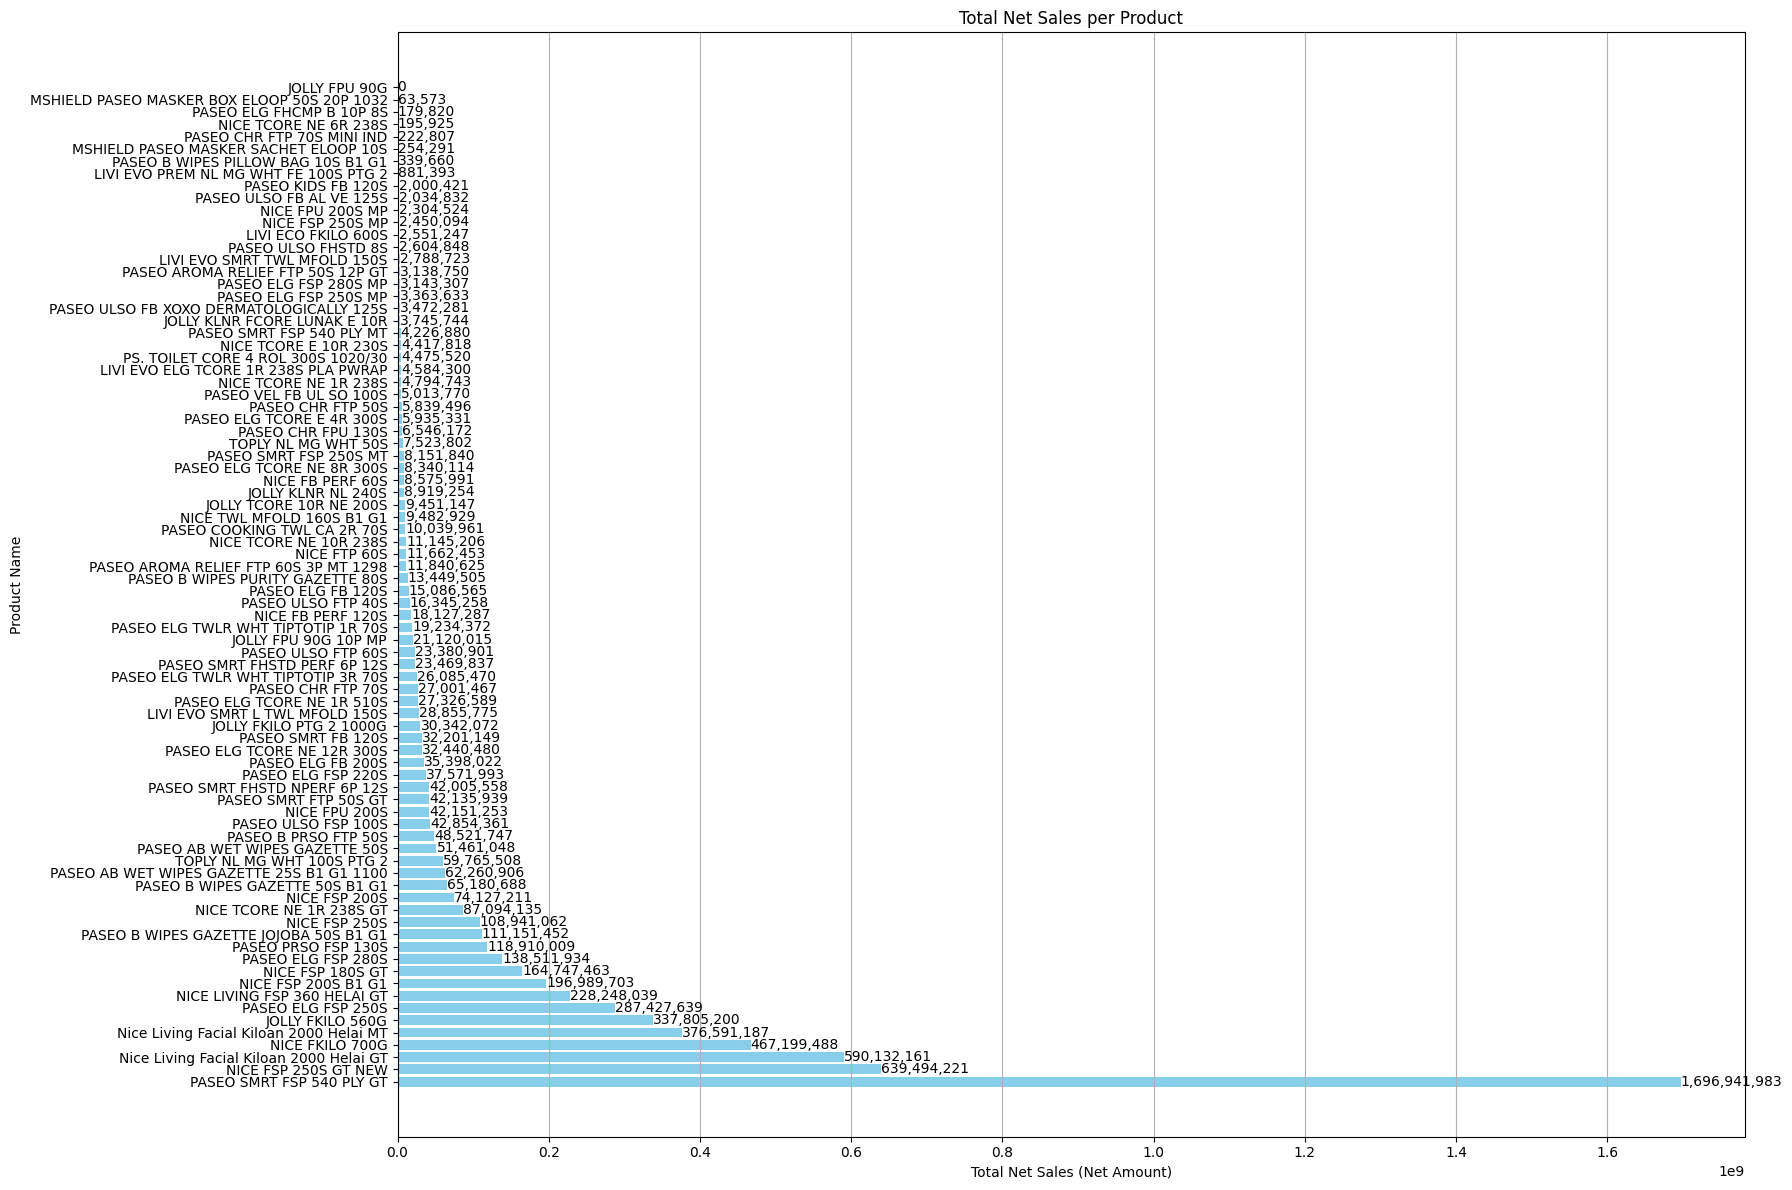

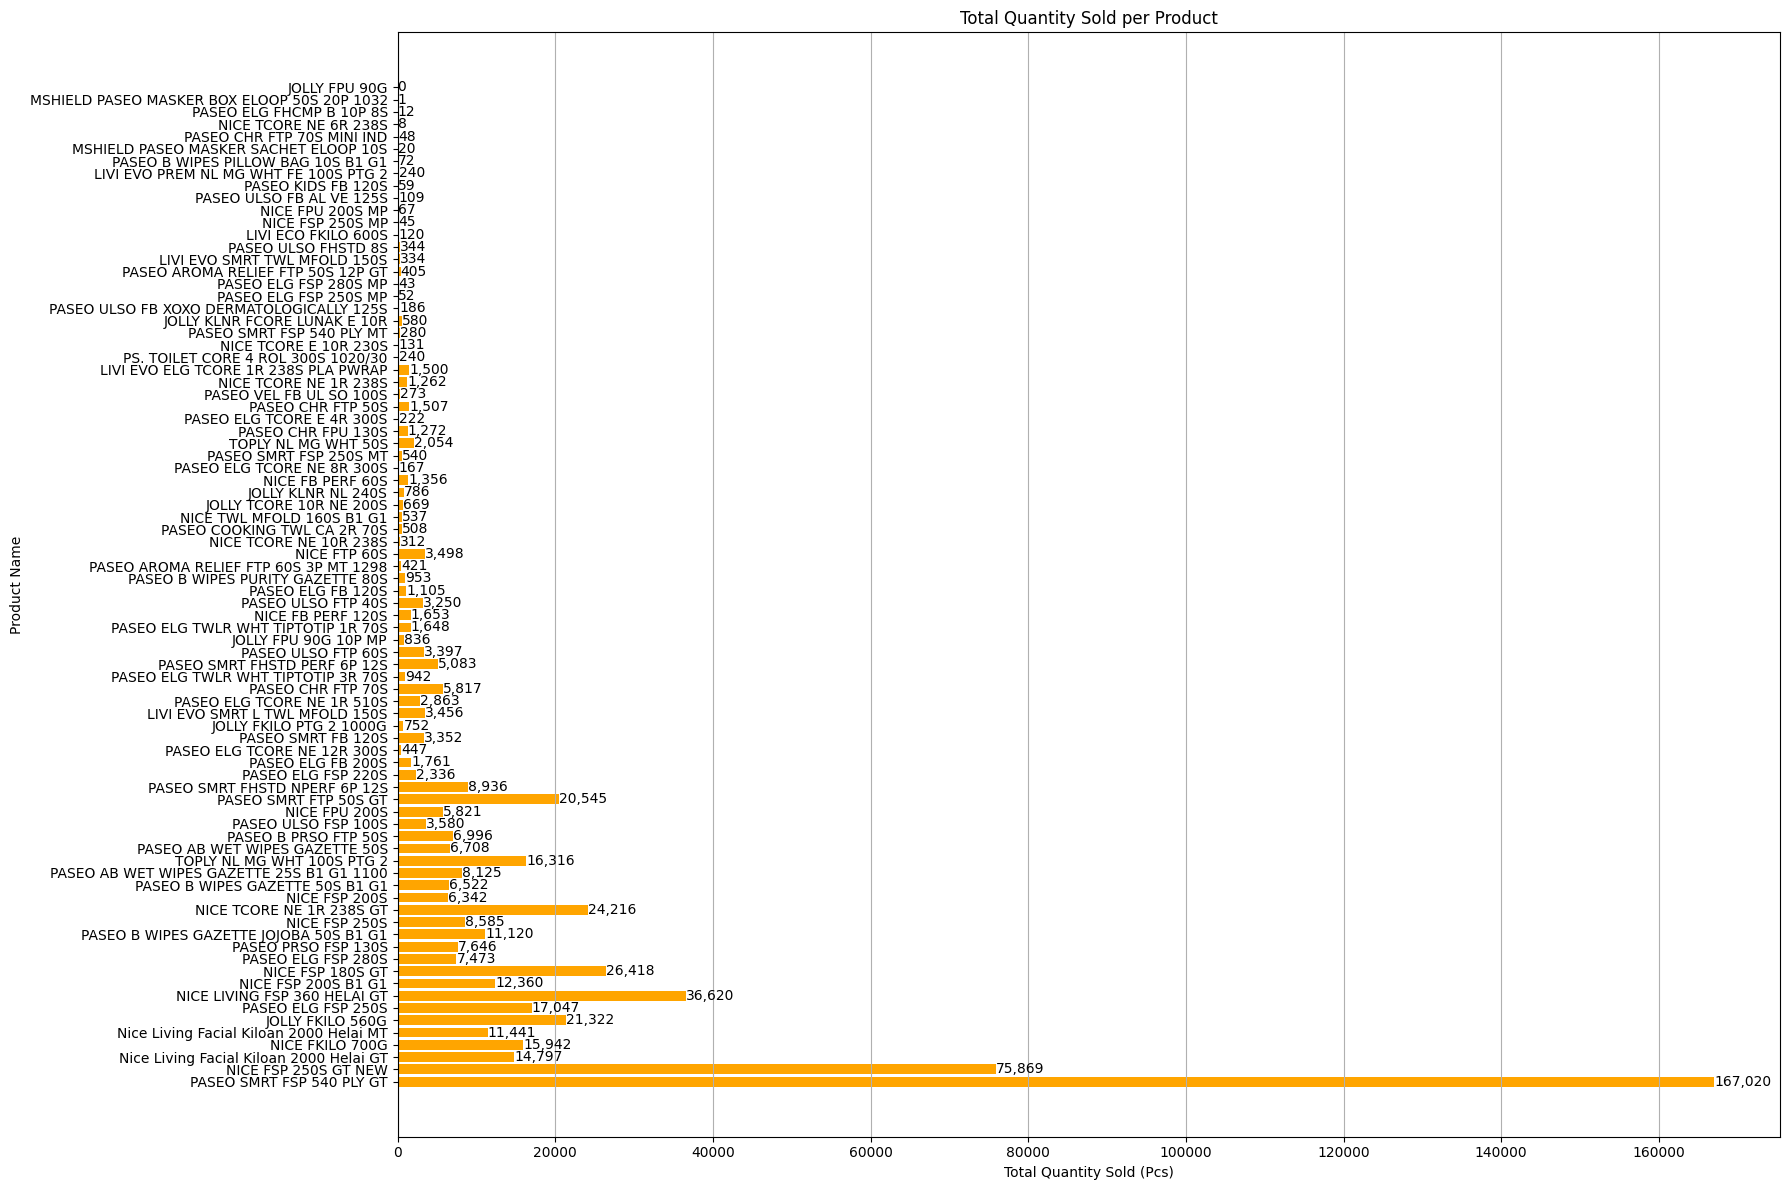

In [ ]:
# Group by 'Product Code' and 'Product Name'
product_summary = data.groupby(['Product Code', 'Product Name']).agg(
    total_sales=('Net Amount', 'sum'),
    transaction_count=('Invoice Date', 'count'),
    total_quantity=('Qty (Pcs)', 'sum')
).reset_index()

product_summary = product_summary.sort_values(by='total_sales', ascending=False)

# Create a figure
plt.figure(figsize=(18, 12))
bars = plt.barh(product_summary['Product Name'], product_summary['total_sales'], color='skyblue')
plt.title('Total Net Sales per Product')
plt.xlabel('Total Net Sales (Net Amount)')
plt.ylabel('Product Name')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x')

# Add labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}',
             va='center', ha='left')
plt.tight_layout()
plt.show()

# Create a figure
plt.figure(figsize=(18, 12))
bars = plt.barh(product_summary['Product Name'], product_summary['total_quantity'], color='orange')
plt.title('Total Quantity Sold per Product')
plt.xlabel('Total Quantity Sold (Pcs)')
plt.ylabel('Product Name')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x')

# Add labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}',
             va='center', ha='left')

plt.tight_layout()
plt.show()

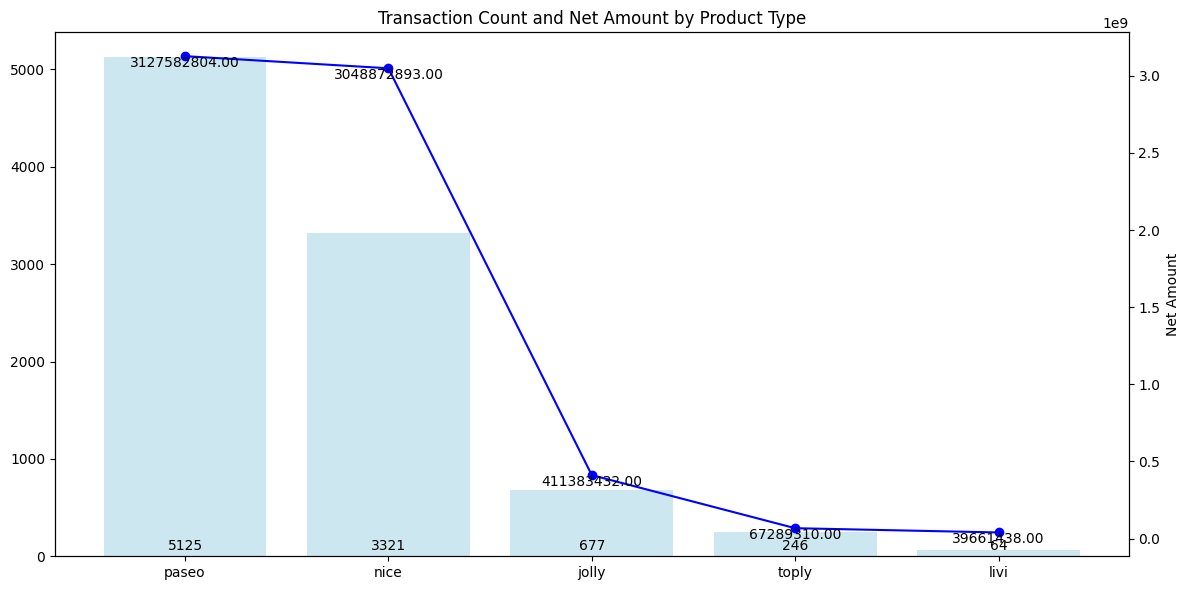

In [ ]:
# Function to clean the Product Code
def clean_product_code(code):
    return ''.join(re.findall(r'[a-zA-Z]+', code)).lower()

# Apply the cleaning
data['Cleaned Product Code'] = data['Product Code'].apply(clean_product_code)

# Group by the cleaned product code
summary = data.groupby('Cleaned Product Code').agg({
    'Invoice Date': 'count',
    'Net Amount': 'sum'
}).rename(columns={'Invoice Date': 'Transaction Count'}).reset_index()

summary = summary.sort_values(by='Net Amount', ascending=False)

# Create a figure
plt.figure(figsize=(12, 6))
bars = plt.bar(summary['Cleaned Product Code'], summary['Transaction Count'], alpha=0.6, label='Transaction Count', color='lightblue')

# Line plot for Net Amount
ax2 = plt.gca().twinx()
line = ax2.plot(summary['Cleaned Product Code'], summary['Net Amount'], marker='o', label='Net Amount', color='blue')

# Adding titles and labels
plt.title('Transaction Count and Net Amount by Product Type')
plt.xlabel('Product Code')
plt.ylabel('Transaction Count')
ax2.set_ylabel('Net Amount')

# Add labels for the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='top')

# Add labels for the line
for i, value in enumerate(summary['Net Amount']):
    ax2.text(i, value, f'{value:.2f}', ha='center', va='top')
plt.tight_layout()
plt.show()

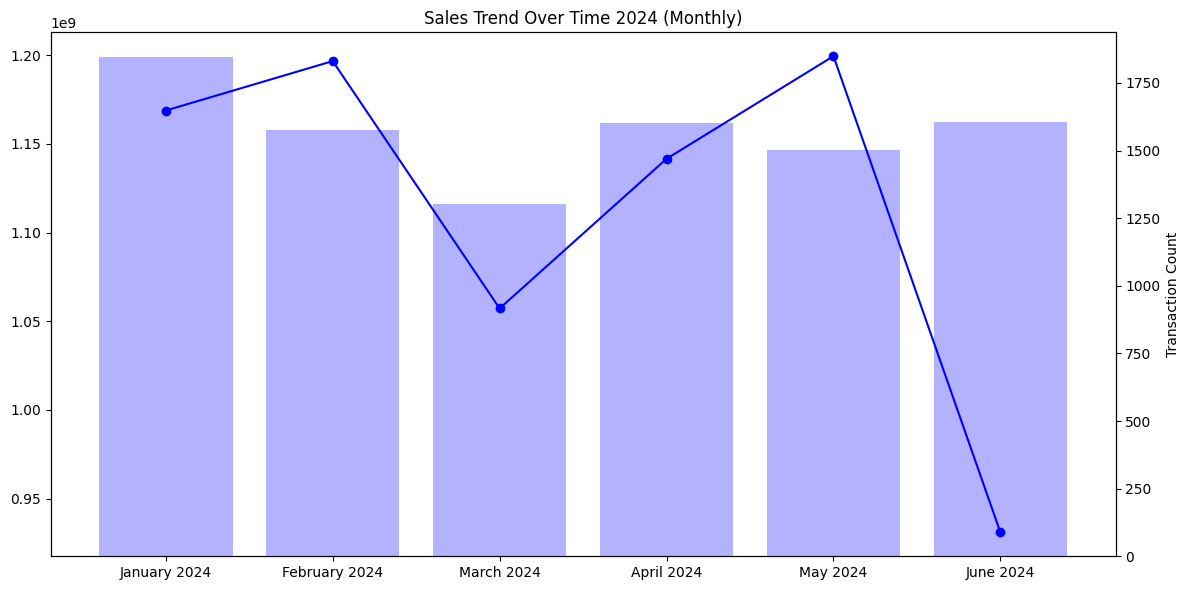

In [ ]:
# Create a 'Month' column
data['Month'] = data['Invoice Date'].dt.to_period('M')

# Group by Month and aggregate total sales and count of transactions
sales_trend = data.groupby('Month').agg({
    'Net Amount': 'sum',
    'Invoice Date': 'count'
}).rename(columns={'Invoice Date': 'Transaction Count'}).reset_index()

# Convert 'Month' to display month names and year
sales_trend['Month'] = sales_trend['Month'].dt.strftime('%B %Y')  # Change to 'Month Year' format

# Create a figure for visualizing the sales trend
plt.figure(figsize=(12, 6))

# Plotting Total Net Amount
plt.plot(sales_trend['Month'], sales_trend['Net Amount'], marker='o', label='Total Net Amount', color='blue')

# Create a second y-axis for Transaction Count
ax2 = plt.gca().twinx()
ax2.bar(sales_trend['Month'], sales_trend['Transaction Count'], alpha=0.3, label='Transaction Count', color='blue')

# Adding titles and labels
plt.title('Sales Trend Over Time 2024 (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Net Amount')
ax2.set_ylabel('Transaction Count')

# Show the plot
plt.tight_layout()
plt.show()


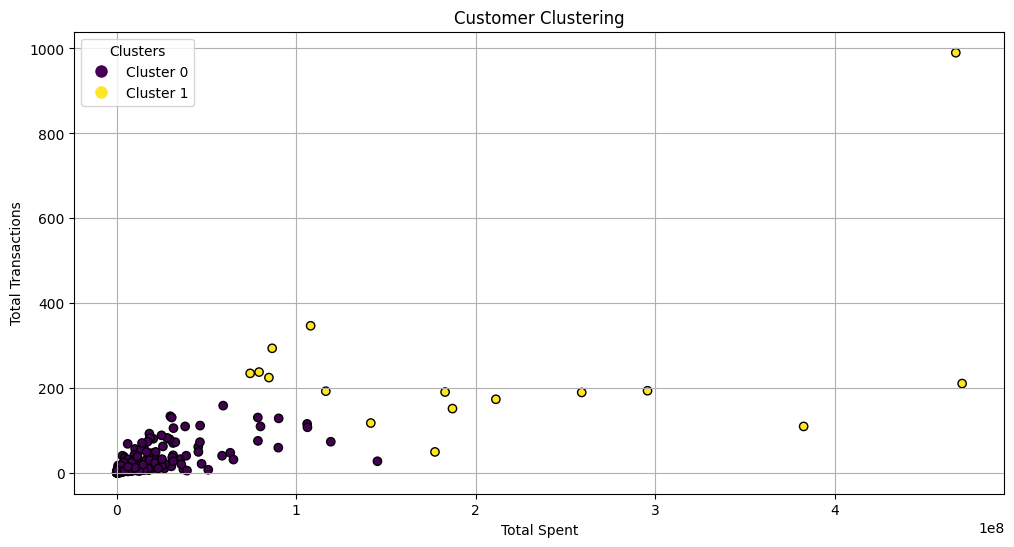

Cluster
0    228
1     16
Name: count, dtype: int64


In [ ]:
# Group by Customer Name
customer_summary = data.groupby('Customer Name').agg(
    total_spent=('Net Amount', 'sum'),
    total_transactions=('Invoice Date', 'count')
).reset_index()

#Standardize
scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_summary[['total_spent', 'total_transactions']])

#K-Means Clustering
k_customers = 2
kmeans_customers = KMeans(n_clusters=k_customers, random_state=42)
customer_summary['Cluster'] = kmeans_customers.fit_predict(customer_features)

#Visualize the Clusters
plt.figure(figsize=(12, 6))
scatter_customers = plt.scatter(customer_summary['total_spent'], customer_summary['total_transactions'],
                                 c=customer_summary['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.title('Customer Clustering')
plt.xlabel('Total Spent')
plt.ylabel('Total Transactions')
handles = []
for cluster in range(k_customers):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                                markerfacecolor=scatter_customers.cmap(scatter_customers.norm(cluster)), markersize=10))

plt.legend(handles=handles, title='Clusters')
plt.grid()
plt.show()

cluster_counts = customer_summary['Cluster'].value_counts()
print(cluster_counts)

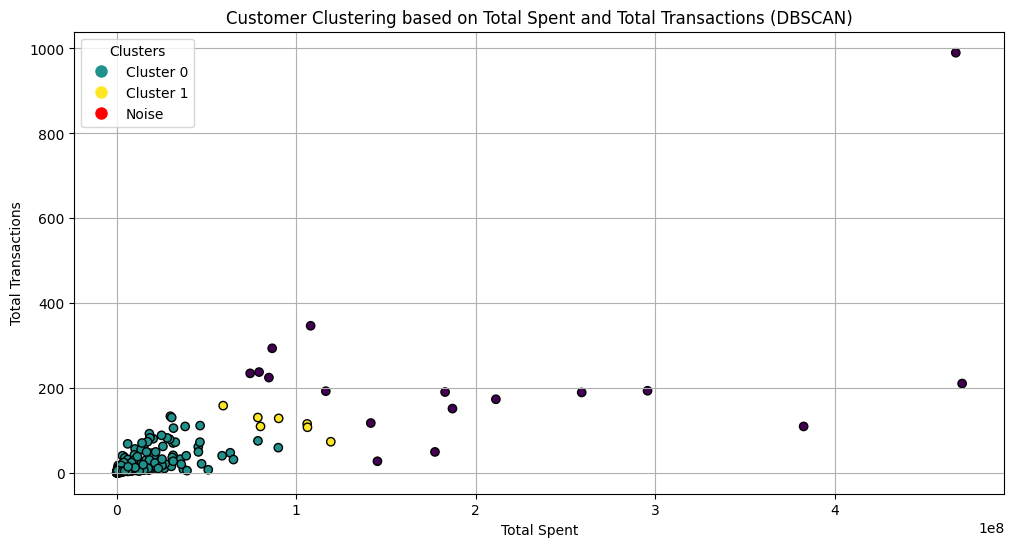

Cluster
 0    220
-1     17
 1      7
Name: count, dtype: int64


In [ ]:
#Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_summary['Cluster'] = dbscan.fit_predict(customer_features)

#Visualize the Clusters for Customers
plt.figure(figsize=(12, 6))
scatter_customers = plt.scatter(customer_summary['total_spent'], customer_summary['total_transactions'],
                                 c=customer_summary['Cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.title('Customer Clustering based on Total Spent and Total Transactions (DBSCAN)')
plt.xlabel('Total Spent')
plt.ylabel('Total Transactions')

# Create a custom legend
unique_clusters = customer_summary['Cluster'].unique()
handles = []
for cluster in unique_clusters:
    if cluster != -1:  # Exclude noise points
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster}',
                                    markerfacecolor=scatter_customers.cmap(scatter_customers.norm(cluster)), markersize=10))
    else:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Noise',
                                    markerfacecolor='red', markersize=10))

plt.legend(handles=handles, title='Clusters')
plt.grid()
plt.show()

cluster_counts = customer_summary['Cluster'].value_counts()
print(cluster_counts)

            Net Amount  Qty (Pcs)
Net Amount    1.000000   0.815882
Qty (Pcs)     0.815882   1.000000


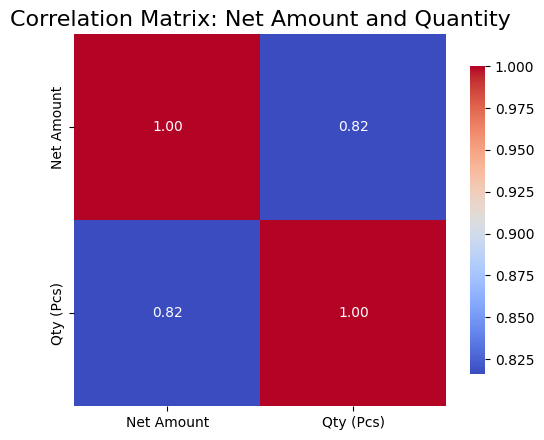

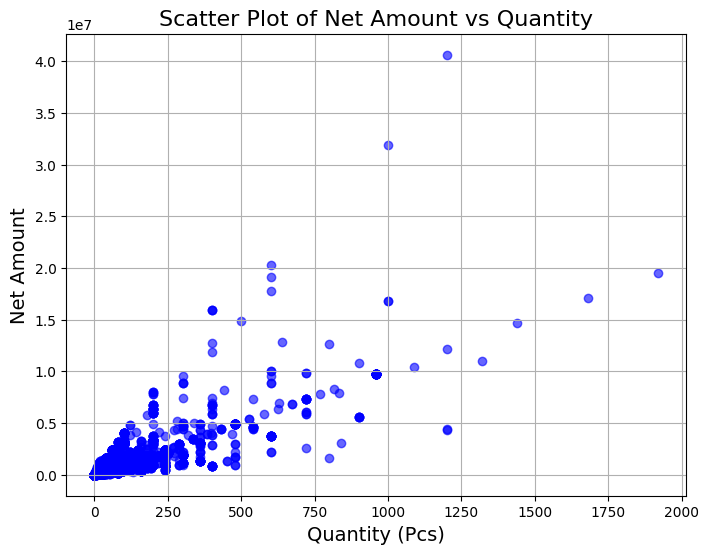

In [ ]:
correlation_data = data[['Net Amount', 'Qty (Pcs)']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix: Net Amount and Quantity', fontsize=16)
plt.show()

# Visualize using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(correlation_data['Qty (Pcs)'], correlation_data['Net Amount'], alpha=0.6, color='blue')
plt.title('Scatter Plot of Net Amount vs Quantity', fontsize=16)
plt.xlabel('Quantity (Pcs)', fontsize=14)
plt.ylabel('Net Amount', fontsize=14)
plt.grid()
plt.show()


Prophet - Mean Absolute Error (MAE): 31219104.96
Prophet - Mean Absolute Percentage Error (MAPE): 83.64%


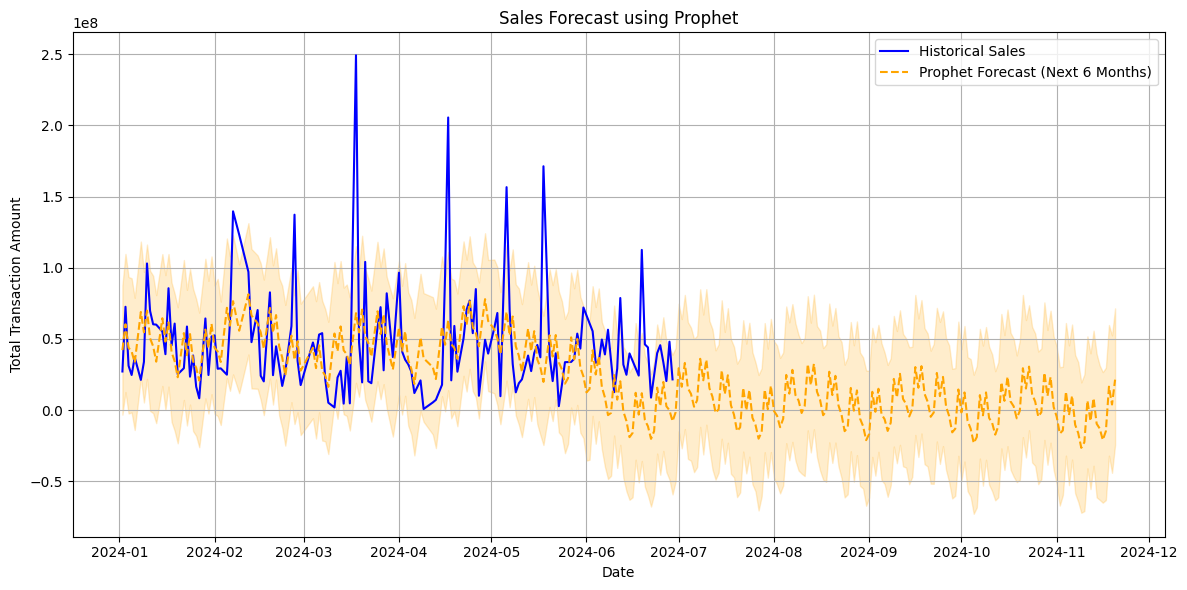

In [ ]:
# Grup data by Invoice date
data_daily = data.groupby('Invoice Date').agg({
    'Net Amount': 'sum'
}).reset_index()

# Rename the columns for Prophet
data_daily.columns = ['ds', 'y']

# Split the data into training and testing
train_size = int(len(data_daily) * 0.8)
train, test = data_daily[:train_size], data_daily[train_size:]

# Initialize and fit the Prophet model
prophet_model = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    daily_seasonality=False
)

# Set a cap for logistic growth
train = train.assign(cap=train['y'].max() * 1.5)
prophet_model.fit(train)

# Create a DataFrame for future dates
future = prophet_model.make_future_dataframe(periods=180, freq='D')
future['cap'] = train['cap'].max()

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Calculate accuracy metrics
test_forecast_prophet = prophet_forecast[prophet_forecast['ds'].isin(test['ds'])]
mae_prophet = mean_absolute_error(test['y'], test_forecast_prophet['yhat'])
mape_prophet = mean_absolute_percentage_error(test['y'], test_forecast_prophet['yhat']) * 100  # Convert to percentage

# Print accuracy metrics
print(f'Prophet - Mean Absolute Error (MAE): {mae_prophet:.2f}')
print(f'Prophet - Mean Absolute Percentage Error (MAPE): {mape_prophet:.2f}%')

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_daily['ds'], data_daily['y'], label='Historical Sales', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast (Next 6 Months)', color='orange', linestyle='--')
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='orange', alpha=0.2)
plt.title('Sales Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



SARIMA - Mean Absolute Error (MAE): 27206261.69
SARIMA - Mean Absolute Percentage Error (MAPE): 88.76%


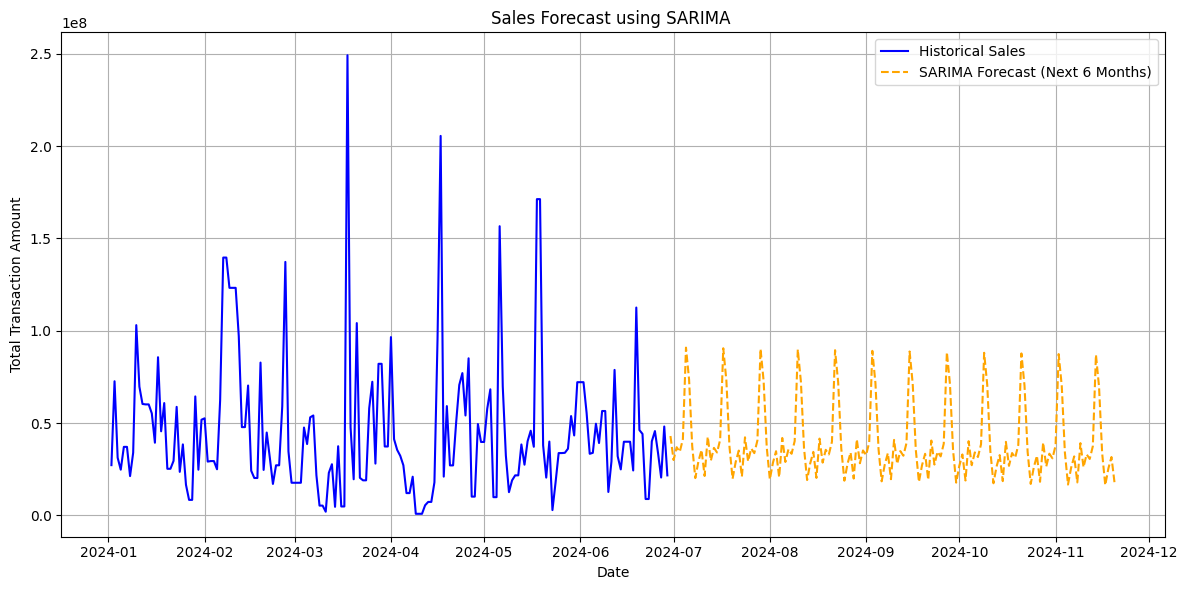

In [ ]:
# Load and prepare the data
data_daily = data.groupby('Invoice Date').agg({
    'Net Amount': 'sum'  # Total sales amount
}).reset_index()

# Rename the columns
data_daily.columns = ['ds', 'y']

# Set 'ds' as the index and ensure it has a frequency
data_daily.set_index('ds', inplace=True)
data_daily = data_daily.asfreq('D')

# Fill missing values if any (forward fill)
data_daily['y'] = data_daily['y'].ffill()

# Fit SARIMA model
# parameters: (p, d, q) x (P, D, Q, s)
sarima_model = SARIMAX(train_sarima, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Forecast the 6 month ahead
forecast_steps = 180
sarima_forecast = sarima_model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data_daily.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
sarima_forecast_series = pd.Series(sarima_forecast, index=forecast_index)

# Calculate accuracy metrics
test_sarima = data_daily['y'][train_size:]
mae_sarima = mean_absolute_error(test_sarima, sarima_forecast_series[:len(test_sarima)])
mape_sarima = mean_absolute_percentage_error(test_sarima, sarima_forecast_series[:len(test_sarima)]) * 100  # Convert to percentage

# Print accuracy metrics
print(f'SARIMA - Mean Absolute Error (MAE): {mae_sarima:.2f}')
print(f'SARIMA - Mean Absolute Percentage Error (MAPE): {mape_sarima:.2f}%')

# Plot the historical data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data_daily.index, data_daily['y'], label='Historical Sales', color='blue')
plt.plot(sarima_forecast_series.index, sarima_forecast_series, label='SARIMA Forecast (Next 6 Months)', color='orange', linestyle='--')
plt.title('Sales Forecast using SARIMA ')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
